In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from models import *
from ucr import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [ ]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [ ]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [ ]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac


In [ ]:
num_classes = df_train.target.nunique(); num_classes

37

# DL

In [ ]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

#some unsqueezing
train_list = ItemList(x_train[:, None, :])
test_list = ItemList(x_test[:, None, :])

src = ItemLists(DATAPATH, train_list, test_list).label_from_lists(y_train, y_test, label_cls=CategoryList)

In [ ]:
src.train[0][0].shape[1]

176

In [ ]:
db = create_databunch(src, 32)

Testing dims at input/output

In [ ]:
for tx, ty in db.train_dl:
    print(tx.shape, ty.shape)

torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([6, 1, 176]) torch.Size([6])


In [ ]:
tx.dtype

torch.float32

## Inception Time

In [ ]:
model = create_inception(1, num_classes).cuda()

In [ ]:
# model = create_inception_resnet(1, num_classes, kss=[39, 19, 9], conv_sizes=[128, 128, 256]).cuda()

In [ ]:
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (conv_bottle): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(3

In [ ]:
model(tx).shape

torch.Size([32, 37])

In [ ]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 3.31E-03


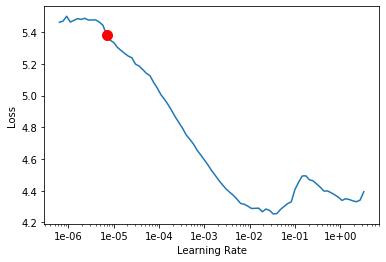

In [ ]:
learn_res.lr_find(); learn_res.recorder.plot(suggestion=True)

In [ ]:
learn_res.fit(40, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,4.020611,3.623675,0.964194,00:02
1,3.687622,3.517063,0.943734,00:02
2,3.446941,3.508390,0.938619,00:02
3,3.269463,2.943579,0.864450,00:01
4,3.077104,2.736858,0.772379,00:01
5,2.871743,2.521662,0.767263,00:02
6,2.688266,3.425415,0.867008,00:02
7,2.522440,3.396404,0.836317,00:02
8,2.391127,2.624297,0.741688,00:02
9,2.232706,3.013608,0.808184,00:02


KeyboardInterrupt: 

In [ ]:
p, t = learn_res.get_preds()

In [ ]:
error_rate(p,t)

tensor(0.4501)

In [ ]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

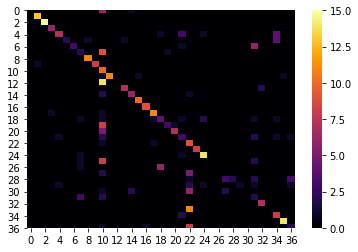

In [ ]:
sns.heatmap(get_cm(p,t), cmap='inferno')